It seems the current [high scoring script][1] is written in R using H2O. So let us do one in python using XGBoost. 

Thanks to [this script][2] for feature engineering ideas. 

We shall start with importing the necessary modules


  [1]: https://www.kaggle.com/gospursgo/two-sigma-connect-rental-listing-inquiries/h2o-starter-pack/run/835757
  [2]: https://www.kaggle.com/aikinogard/two-sigma-connect-rental-listing-inquiries/random-forest-starter-with-numerical-features

In [1]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
#import xgboost as xgb
#from sklearn import model_selection, preprocessing, ensemble
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.metrics.scorer import make_scorer
#from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from XGBoostPackage import xgbClass
from CrossValidation2 import CVScore

%matplotlib inline

# from sklearn.cross_validation import KFold

In [2]:
# X_train=pd.read_csv('X_train1.csv')
# #X_test=pd.read_csv('X_test1.csv')
# y_train=pd.read_csv('y_train.csv')['interest_level'].ravel()

In [3]:
X_train=pd.read_csv('X_train2.csv').iloc[:,1:]
X_test=pd.read_csv('X_test2.csv')
y_train=pd.read_csv('y_train.csv')['interest_level'].ravel()
for i in [0,1,2]:
    X_train=X_train[~pd.isnull(X_train.iloc[:,i])]

In [ ]:
X_train.shape, y_train.shape

((49352, 227), (49352L,))

In [ ]:
param_grid = {'n_estimators':[500, 600, 700, 800, 900, 1000], 'max_features':['auto','sqrt'], 'max_depth':[15,20,25,None]}
for n_est in param_grid['n_estimators']:
    for max_feat in param_grid['max_features']:
        for max_d in param_grid['max_depth']:
            model=RandomForestClassifier(n_estimators=n_est, max_features=max_feat, max_depth=max_d)
            score=CVScore(model=model, my_score=log_loss, X_train=X_train.iloc[:,:], \
                          y_train=y_train[:])
            print('n_est={}, max_feat={}, max_d={}, score={}'.format(n_est, max_feat, max_d, score))

n_est=500, max_feat=auto, max_d=15, score=0.575939149928
n_est=500, max_feat=auto, max_d=20, score=0.563798419049
n_est=500, max_feat=auto, max_d=25, score=0.561509093035
n_est=500, max_feat=auto, max_d=None, score=0.563241220069
n_est=500, max_feat=sqrt, max_d=15, score=0.575862871816
n_est=500, max_feat=sqrt, max_d=20, score=0.563595295425
n_est=500, max_feat=sqrt, max_d=25, score=0.562280322019
n_est=500, max_feat=sqrt, max_d=None, score=0.563433619878
n_est=600, max_feat=auto, max_d=15, score=0.575573790034
n_est=600, max_feat=auto, max_d=20, score=0.563443359022
n_est=600, max_feat=auto, max_d=25, score=0.561556830448
n_est=600, max_feat=auto, max_d=None, score=0.563591044232
n_est=600, max_feat=sqrt, max_d=15, score=0.575717801329
n_est=600, max_feat=sqrt, max_d=20, score=0.563520168194
n_est=600, max_feat=sqrt, max_d=25, score=0.56204881201
n_est=600, max_feat=sqrt, max_d=None, score=0.56543067616
n_est=700, max_feat=auto, max_d=15, score=0.575586487251
n_est=700, max_feat=auto,

In [17]:
model=RandomForestClassifier(n_estimators=n_est, max_features=max_feat, max_depth=max_d)
model.fit(X_train, y_train)
preds= model.predict(X_test)
out_df = pd.DataFrame(preds)
out_df.columns = ["high_RF", "medium_RF", "low_RF"]
out_df["listing_id"] = X_test.listing_id.values
out_df.to_csv("apr16_1_RF.csv", index=False)

In [10]:
param_grid = {'n_estimators':[500, 600, 700, 800, 900, 1000], 'max_features':['auto','sqrt'], 'max_depth':[4,5,6,7,8,9]}
for n_est in param_grid['n_estimators']:
    for max_feat in param_grid['max_features']:
        for max_d in param_grid['max_depth']:
            model=RandomForestClassifier(n_estimators=n_est, max_features=max_feat, max_depth=max_d)
            score=CVScore(model=model, my_score=log_loss, X_train=train_X, y_train=train_y)
            print('n_est={}, max_feat={}, max_d={}, score={}'.format(n_est, max_feat, max_d, score))

n_est=500, max_feat=auto, max_d=4, score=0.734177433683
n_est=500, max_feat=auto, max_d=5, score=0.722442742144
n_est=500, max_feat=auto, max_d=6, score=0.71138682
n_est=500, max_feat=auto, max_d=7, score=0.700894118829
n_est=500, max_feat=auto, max_d=8, score=0.691463085093
n_est=500, max_feat=auto, max_d=9, score=0.683010332452
n_est=500, max_feat=sqrt, max_d=4, score=0.733710487873
n_est=500, max_feat=sqrt, max_d=5, score=0.721481780477
n_est=500, max_feat=sqrt, max_d=6, score=0.711668884569
n_est=500, max_feat=sqrt, max_d=7, score=0.70140229101
n_est=500, max_feat=sqrt, max_d=8, score=0.691907428753
n_est=500, max_feat=sqrt, max_d=9, score=0.682682357258
n_est=600, max_feat=auto, max_d=4, score=0.733142832136
n_est=600, max_feat=auto, max_d=5, score=0.723107494445
n_est=600, max_feat=auto, max_d=6, score=0.711028627808
n_est=600, max_feat=auto, max_d=7, score=0.70173313679
n_est=600, max_feat=auto, max_d=8, score=0.692280003381
n_est=600, max_feat=auto, max_d=9, score=0.68339723629

In [11]:
param_grid = {'n_estimators':[500, 600, 700, 800, 900, 1000], 'max_features':['auto','sqrt'], 'max_depth':[10,11,12,None]}
for n_est in param_grid['n_estimators']:
    for max_feat in param_grid['max_features']:
        for max_d in param_grid['max_depth']:
            model=RandomForestClassifier(n_estimators=n_est, max_features=max_feat, max_depth=max_d)
            score=CVScore(model=model, my_score=log_loss, X_train=train_X, y_train=train_y)
            print('n_est={}, max_feat={}, max_d={}, score={}'.format(n_est, max_feat, max_d, score))

n_est=500, max_feat=auto, max_d=10, score=0.674754759203
n_est=500, max_feat=auto, max_d=11, score=0.666802482387
n_est=500, max_feat=auto, max_d=12, score=0.659501504894
n_est=500, max_feat=auto, max_d=None, score=0.606367321785
n_est=500, max_feat=sqrt, max_d=10, score=0.674369374442
n_est=500, max_feat=sqrt, max_d=11, score=0.666308881551
n_est=500, max_feat=sqrt, max_d=12, score=0.658666893395
n_est=500, max_feat=sqrt, max_d=None, score=0.606519042036
n_est=600, max_feat=auto, max_d=10, score=0.674476250364
n_est=600, max_feat=auto, max_d=11, score=0.666582328749
n_est=600, max_feat=auto, max_d=12, score=0.659435355714
n_est=600, max_feat=auto, max_d=None, score=0.605120265803
n_est=600, max_feat=sqrt, max_d=10, score=0.674738351622
n_est=600, max_feat=sqrt, max_d=11, score=0.666760395592
n_est=600, max_feat=sqrt, max_d=12, score=0.658920510842
n_est=600, max_feat=sqrt, max_d=None, score=0.605246053838
n_est=700, max_feat=auto, max_d=10, score=0.675137281412
n_est=700, max_feat=aut

Now let us build the final model and get the predictions on the test set.

In [11]:
preds, model = runXGB(train_X, train_y, test_X, num_rounds=400)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_starter2.csv", index=False)


Hope this helps the python users as a good starting point.

In [28]:
imp=pd.DataFrame()#(index=features_to_use)
imp['train'] = pd.Series(model.get_score(importance_type='gain'))#, index=features_to_use)
imp = imp.fillna(0)

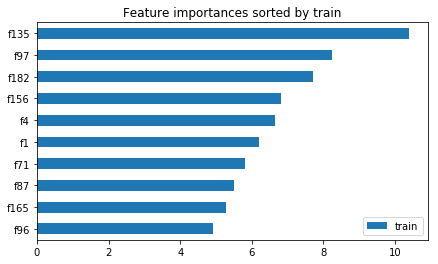

In [30]:
ax=imp.sort_values('train').tail(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))
